# Incremental Feature Selection using mRMR and MCFS


In this notebook, we select features using IFS with RandomForest and Decision Trees. The paper used PART from WEKA but we are using python and SKLEARN doe snot have the implementation of PART , for now we just replace it with DecisionTrees.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from imblearn.over_sampling import SMOTE
import seaborn as sns
from myworkspaceutils.feature_selection.ifs import incremental_feature_selection


plt.style.use('seaborn-v0_8')
%matplotlib inline


##### Load Data

In [2]:
data_dir = f"{Path.cwd().parent.parent}/data"
selected_features_df = pd.read_csv(f'{data_dir}/boruta_selected_features.csv') 
filtered_series_matrix = pd.read_csv(f'{data_dir}/filtered_expression_matrix.csv')
sample_labels = pd.read_csv(f'{data_dir}/GSE120584_sample_labels.csv')

In [3]:
filtered_series_matrix.set_index('ID_REF').transpose()

ID_REF,MIMAT0000245,MIMAT0005588,MIMAT0005905,MIMAT0007349,MIMAT0007401,MIMAT0012735,MIMAT0014984,MIMAT0015064,MIMAT0016849,MIMAT0016889,...,MIMAT0027455,MIMAT0027468,MIMAT0027488,MIMAT0027512,MIMAT0027559,MIMAT0027565,MIMAT0027575,MIMAT0027583,MIMAT0027650,MIMAT0030429
GSM3403761,3.247633,4.666568,6.424362,4.314688,4.302577,6.650482,4.238956,8.011701,10.500005,8.523402,...,5.275861,12.611517,8.237558,6.529971,3.622694,3.235115,8.941666,8.708576,9.349540,3.870470
GSM3403762,3.322302,4.239831,5.908149,4.202207,3.655424,6.558620,3.984927,8.076476,10.529963,8.490272,...,5.401522,12.352932,8.447908,6.375578,3.564422,3.414534,8.746977,8.265670,9.189681,4.857441
GSM3403763,3.832967,3.841522,5.786100,3.974663,3.967952,6.485145,3.510813,8.778496,9.664737,8.609705,...,5.360779,12.854630,8.483502,6.609619,3.826803,3.400731,8.727991,8.239926,9.783502,2.941832
GSM3403764,3.099451,4.553042,6.202725,4.258664,3.724011,6.697673,4.021334,7.672666,10.533419,8.901371,...,5.423035,12.364354,8.053725,7.169810,2.596518,2.117638,8.872228,8.677822,8.823568,2.940942
GSM3403765,3.972978,4.213964,6.438405,4.458520,3.179096,6.520311,3.179096,7.671334,10.554191,8.822575,...,4.964842,12.327902,7.974729,6.399604,4.104722,3.179096,8.924293,8.607664,9.011754,4.008777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3405357,2.755368,4.321873,7.085877,4.856806,2.321851,7.076784,5.177382,7.916001,11.345804,8.494325,...,5.614878,12.790379,8.198811,6.937548,3.844585,3.187042,9.238711,9.095730,9.473596,4.434988
GSM3405358,3.247889,4.677839,6.681850,4.574527,4.004131,7.215211,4.141063,8.617582,10.899580,8.960655,...,5.834998,13.517037,8.814521,6.820251,4.444684,3.247889,9.405115,8.893351,10.032701,3.247889
GSM3405359,4.054153,4.697839,7.013891,4.858040,4.048914,6.706661,5.440901,8.022583,11.241062,8.867058,...,5.346011,12.455277,8.340961,5.981719,2.797777,3.783744,8.690911,8.476562,9.420849,4.188238
GSM3405360,3.463225,4.651253,6.715800,4.695997,3.743187,6.854207,4.897255,8.303287,11.194294,8.610445,...,5.322002,12.836729,8.451316,6.440157,3.927342,3.224683,9.102245,8.059508,9.610215,3.111256


In [4]:
X = filtered_series_matrix.set_index('ID_REF').transpose()
y = np.array([sample_labels[sample_labels['Sample ID'] == sample_id]['LABEL'] for sample_id in filtered_series_matrix.columns[1:]]).flatten()

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label encoding:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  {class_name} --- {i}")

Label encoding:
  AD --- 0
  DLB --- 1
  MCI --- 2
  NC --- 3
  VaD --- 4


In [6]:
mrmr_ranking_df = pd.read_csv(f'{data_dir}/mrmr_feature_ranking.csv')
mcfs_ranking_df = pd.read_csv(f'{data_dir}/mcfs_feature_ranking.csv')

In [7]:
mrmr_ranking_df.head()

,mrmr_rank,feature_name
0,1,MIMAT0027423
1,2,MIMAT0027468
2,3,MIMAT0016889
3,4,MIMAT0014984
4,5,MIMAT0027455


In [8]:
mcfs_ranking_df.head()

,mcfs_rank,feature_name,importance_score
0,1,MIMAT0027575,0.040921
1,2,MIMAT0014984,0.040768
2,3,MIMAT0027512,0.040183
3,4,MIMAT0007349,0.039983
4,5,MIMAT0027423,0.037572


In [9]:
# Get feature by ranking from both methods
mrmr_features = mrmr_ranking_df['feature_name'].tolist()
mcfs_features = mcfs_ranking_df['feature_name'].tolist()

In [10]:
mrmr_rf_results = incremental_feature_selection(
    X, y_encoded, mrmr_features
)

  Testing with 30 features...: 100%|██████████| 30/30 [05:24<00:00, 10.81s/it]


In [11]:
mcfs_rf_results = incremental_feature_selection(
    X, y_encoded, mcfs_features
)


  Testing with 30 features...: 100%|██████████| 30/30 [05:27<00:00, 10.92s/it]


In [12]:
mrmr_rf_results.keys()

dict_keys(['rf_mcc', 'rf_acc', 'part_mcc', 'part_acc'])

In [13]:
result_df = pd.DataFrame()

result_df['n_features'] = range(1, len(mrmr_rf_results['rf_mcc']) + 1)
result_df['mrmr_rf_mcc'] =  mrmr_rf_results['rf_mcc']
result_df['mrmr_rf_acc'] =  mrmr_rf_results['rf_acc']
result_df['mrmr_dt_mcc'] =  mrmr_rf_results['part_mcc']
result_df['mrmr_dt_acc'] =  mrmr_rf_results['part_acc']

result_df['mcfs_rf_mcc'] =  mcfs_rf_results['rf_mcc']
result_df['mcfs_rf_acc'] =  mcfs_rf_results['rf_acc']
result_df['mcfs_dt_mcc'] =  mcfs_rf_results['part_mcc']
result_df['mcfs_dt_acc'] =  mcfs_rf_results['part_acc']

In [14]:
print(result_df.shape)
result_df.head()

(30, 9)


,n_features,mrmr_rf_mcc,mrmr_rf_acc,mrmr_dt_mcc,mrmr_dt_acc,mcfs_rf_mcc,mcfs_rf_acc,mcfs_dt_mcc,mcfs_dt_acc
0,1,0.169088,0.335162,0.256746,0.404509,0.143149,0.314396,0.201282,0.359458
1,2,0.484054,0.586098,0.350329,0.477572,0.502259,0.600790,0.365760,0.490708
2,3,0.660645,0.726933,0.418134,0.532030,0.646830,0.715577,0.420356,0.533984
3,4,0.763995,0.809014,0.436029,0.542613,0.746541,0.795305,0.455248,0.561417
4,5,0.802297,0.839377,0.517132,0.611361,0.796723,0.835852,0.509309,0.604900


In [15]:
# Optimal ftrs ased on mcc score
def get_optimal_ftrs(mcc_scores, ranking_name):
    opt_index = np.argmax(mcc_scores)
    best_mcc = mcc_scores[opt_index]
    optimal_ftrs = opt_index + 1
    
    print(f"{ranking_name}:")
    print(f"Features: {optimal_ftrs}")
    print(f"Best MCC: {best_mcc:.4f}")
    
    return optimal_ftrs, best_mcc

In [16]:
# Random Forest
print("RF:")
mrmr_optimal_n_rf, mrmr_optimal_mcc_rf = get_optimal_ftrs(result_df['mrmr_rf_mcc'], "mRMR")
mcfs_optimal_n_rf, mcfs_optimal_mcc_rf = get_optimal_ftrs(result_df['mcfs_rf_mcc'], "MCFS")

print("DT:")
# Decision Trees
mrmr_optimal_n_dt, mrmr_optimal_mcc_dt = get_optimal_ftrs(result_df['mrmr_dt_mcc'], "mRMR")
mcfs_optimal_n_dt, mcfs_optimal_mcc_dt = get_optimal_ftrs(result_df['mcfs_dt_mcc'], "MCFS")

RF:
mRMR:
Features: 29
Best MCC: 0.9169
MCFS:
Features: 26
Best MCC: 0.9218
DT:
mRMR:
Features: 28
Best MCC: 0.6432
MCFS:
Features: 27
Best MCC: 0.6498


### Plotting the results

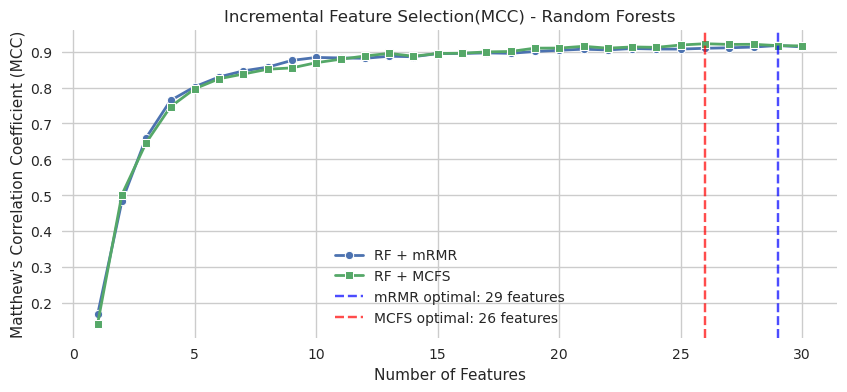

In [17]:
mrmr_rf_mcc = result_df['mrmr_rf_mcc'].tolist()
mcfs_rf_mcc = result_df['mcfs_rf_mcc'].tolist()


data_mcc = pd.DataFrame({
    'Number of Features': list(range(1, len(mrmr_rf_mcc) + 1)) * 2,
    'Matthew\'s Correlation Coefficient (MCC)': mrmr_rf_mcc + mcfs_rf_mcc,
    'method': ['RF + mRMR'] * len(mrmr_rf_mcc) + ['RF + MCFS'] * len(mcfs_rf_mcc)
})

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid") 
sns.lineplot(data=data_mcc, x='Number of Features', y='Matthew\'s Correlation Coefficient (MCC)', hue='method', 
             style='method', markers=['o', 's'], markersize=6,
             linewidth=2, dashes=False)
plt.axvline(x=mrmr_optimal_n_rf, color='blue', linestyle='--', alpha=0.7, label=f'mRMR optimal: {mrmr_optimal_n_rf} features')
plt.axvline(x=mcfs_optimal_n_rf, color='red', linestyle='--', alpha=0.7, label=f'MCFS optimal: {mcfs_optimal_n_rf} features')

plt.title('Incremental Feature Selection(MCC) - Random Forests')

plt.legend()

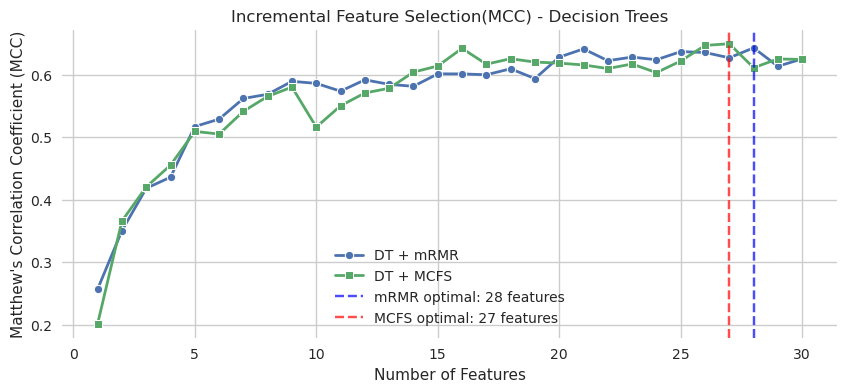

In [18]:
mrmr_dt_mcc = result_df['mrmr_dt_mcc'].tolist()
mcfs_dt_mcc = result_df['mcfs_dt_mcc'].tolist()


data_mcc = pd.DataFrame({
    'Number of Features': list(range(1, len(mrmr_dt_mcc) + 1)) * 2,
    'Matthew\'s Correlation Coefficient (MCC)': mrmr_dt_mcc + mcfs_dt_mcc,
    'method': ['DT + mRMR'] * len(mrmr_dt_mcc) + ['DT + MCFS'] * len(mcfs_dt_mcc)
})

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid") 
sns.lineplot(data=data_mcc, x='Number of Features', y='Matthew\'s Correlation Coefficient (MCC)', hue='method', 
             style='method', markers=['o', 's'], markersize=6,
             linewidth=2, dashes=False)
plt.axvline(x=mrmr_optimal_n_dt, color='blue', linestyle='--', alpha=0.7, label=f'mRMR optimal: {mrmr_optimal_n_dt} features')
plt.axvline(x=mcfs_optimal_n_dt, color='red', linestyle='--', alpha=0.7, label=f'MCFS optimal: {mcfs_optimal_n_dt} features')

plt.title('Incremental Feature Selection(MCC) - Decision Trees')

plt.legend()

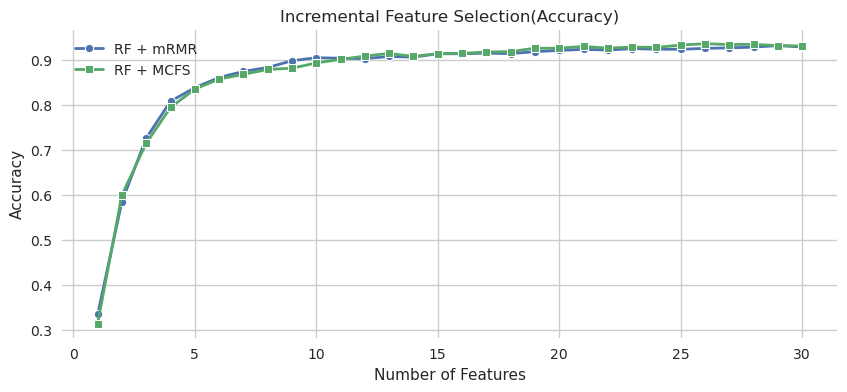

In [19]:
mrmr_rf_acc = result_df['mrmr_rf_acc'].tolist()
mcfs_rf_acc = result_df['mcfs_rf_acc'].tolist()


data_acc = pd.DataFrame({
    'Number of Features': list(range(1, len(mrmr_rf_acc) + 1)) * 2,
    'Accuracy': mrmr_rf_acc + mcfs_rf_acc,
    'method': ['RF + mRMR'] * len(mrmr_rf_acc) + ['RF + MCFS'] * len(mcfs_rf_acc)
})

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid") 
sns.lineplot(data=data_acc, x='Number of Features', y='Accuracy', hue='method', 
             style='method', markers=['o', 's'], markersize=6,
             linewidth=2, dashes=False)
 
plt.title('Incremental Feature Selection(Accuracy)')

plt.legend()

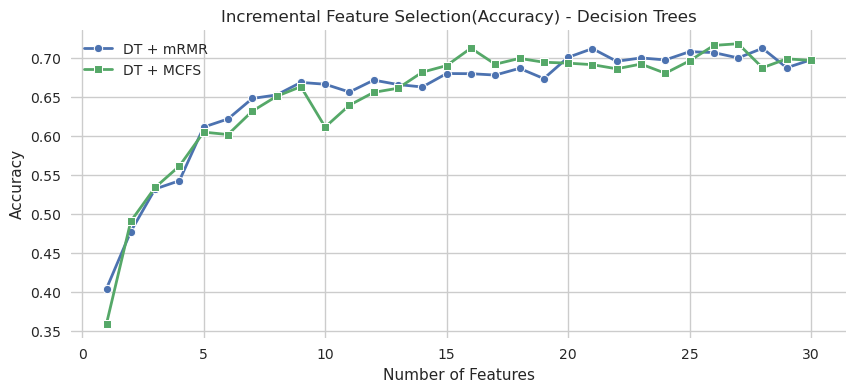

In [20]:
mrmr_dt_acc = result_df['mrmr_dt_acc'].tolist()
mcfs_dt_acc = result_df['mcfs_dt_acc'].tolist()


data_acc = pd.DataFrame({
    'Number of Features': list(range(1, len(mrmr_dt_acc) + 1)) * 2,
    'Accuracy': mrmr_dt_acc + mcfs_dt_acc,
    'method': ['DT + mRMR'] * len(mrmr_dt_acc) + ['DT + MCFS'] * len(mcfs_dt_acc)
})

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid") 
sns.lineplot(data=data_acc, x='Number of Features', y='Accuracy', hue='method', 
             style='method', markers=['o', 's'], markersize=6,
             linewidth=2, dashes=False)
 
plt.title('Incremental Feature Selection(Accuracy) - Decision Trees')

plt.legend()

In [21]:
optimal_subsets = {
    'ranking_method': ['mRMR', 'mRMR', 'MCFS', 'MCFS'],
    'classifier': ['RF', 'DT', 'RF', 'DT'],
    'optimal_features': [mrmr_optimal_n_rf, mrmr_optimal_n_dt, mcfs_optimal_n_rf, mcfs_optimal_n_dt],
    'best_mcc': [mrmr_optimal_mcc_rf, mrmr_optimal_mcc_dt, mcfs_optimal_mcc_rf, mcfs_optimal_mcc_dt],
    'optimal_feature_names': [mrmr_features[:mrmr_optimal_n_rf], mrmr_features[:mrmr_optimal_n_dt], mcfs_features[:mcfs_optimal_n_rf], mcfs_features[:mcfs_optimal_n_dt]],
     
}
optimal_df = pd.DataFrame(optimal_subsets)
optimal_df

,ranking_method,classifier,optimal_features,best_mcc,optimal_feature_names
0,mRMR,RF,29,0.916929,"[MIMAT0027423, MIMAT0027468, MIMAT0016889, MIM..."
1,mRMR,DT,28,0.643162,"[MIMAT0027423, MIMAT0027468, MIMAT0016889, MIM..."
2,MCFS,RF,26,0.921822,"[MIMAT0027575, MIMAT0014984, MIMAT0027512, MIM..."
3,MCFS,DT,27,0.649763,"[MIMAT0027575, MIMAT0014984, MIMAT0027512, MIM..."


In [22]:
result_df.to_csv(f'{data_dir}/ifs_results.csv', index=False)
optimal_df.to_csv(f'{data_dir}/optimal_feature_subsets_ifs.csv', index=False)

## Comparing plots for mRMR wth RF and DT as classifiers (Figure 3 A in the paper)

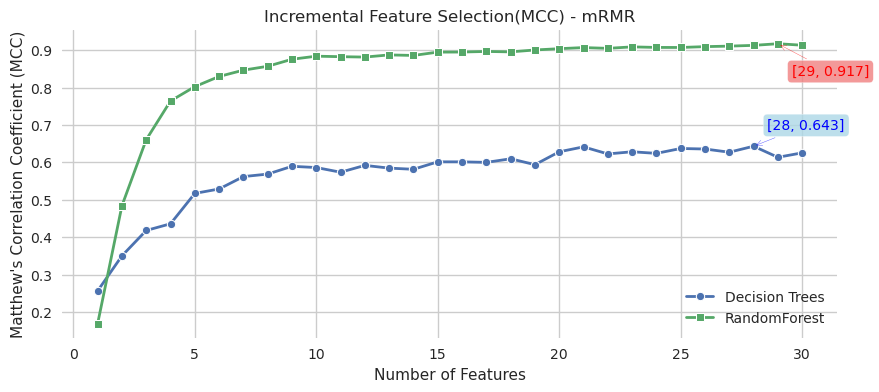

In [23]:
mrmr_dt_mcc = result_df['mrmr_dt_mcc'].tolist()
mrmr_rf_mcc = result_df['mrmr_rf_mcc'].tolist()


data_mcc = pd.DataFrame({
    'Number of Features': list(range(1, len(mrmr_dt_mcc) + 1)) * 2,
    'Matthew\'s Correlation Coefficient (MCC)': mrmr_dt_mcc + mrmr_rf_mcc,
    'classifier': ['Decision Trees'] * len(mrmr_dt_mcc) + ['RandomForest'] * len(mrmr_rf_mcc)
})

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid") 
ax = sns.lineplot(data=data_mcc, x='Number of Features', y='Matthew\'s Correlation Coefficient (MCC)', hue='classifier', 
             style='classifier', markers=['o', 's'], markersize=6,
             linewidth=2, dashes=False) 

dt_optimal_mcc = mrmr_dt_mcc[mrmr_optimal_n_dt - 1]  # -1 because list is 0-indexed
ax.annotate(f'[{mrmr_optimal_n_dt}, {dt_optimal_mcc:.3f}]', 
            xy=(mrmr_optimal_n_dt, dt_optimal_mcc),
            xytext=(10, 10), textcoords='offset points',
            color='blue', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7))


rf_optimal_mcc = mrmr_rf_mcc[mrmr_optimal_n_rf - 1]
ax.annotate(f'[{mrmr_optimal_n_rf}, {rf_optimal_mcc:.3f}]', 
            xy=(mrmr_optimal_n_rf, rf_optimal_mcc),
            xytext=(10, -15), textcoords='offset points',
            color='red', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

plt.title('Incremental Feature Selection(MCC) - mRMR')

plt.legend()

## Comparing plots for MCFS wth RF and DT as classifiers (Figure 3 B in the paper)

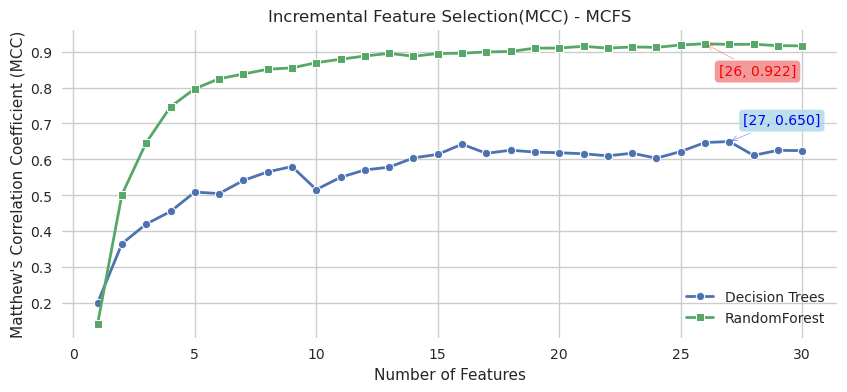

In [24]:
data_mcc_mcfs = pd.DataFrame({
    'Number of Features': list(range(1, len(mcfs_dt_mcc) + 1)) * 2,
    'Matthew\'s Correlation Coefficient (MCC)': mcfs_dt_mcc + mcfs_rf_mcc,
    'classifier': ['Decision Trees'] * len(mcfs_dt_mcc) + ['RandomForest'] * len(mcfs_rf_mcc)
})

plt.figure(figsize=(10, 4))
sns.set_style("whitegrid") 
ax = sns.lineplot(data=data_mcc_mcfs, x='Number of Features', y='Matthew\'s Correlation Coefficient (MCC)', hue='classifier', 
             style='classifier', markers=['o', 's'], markersize=6,
             linewidth=2, dashes=False)


dt_optimal_mcc = mcfs_dt_mcc[mcfs_optimal_n_dt - 1]  # -1 because list is 0-indexed
ax.annotate(f'[{mcfs_optimal_n_dt}, {dt_optimal_mcc:.3f}]', 
            xy=(mcfs_optimal_n_dt, dt_optimal_mcc),
            xytext=(10, 10), textcoords='offset points',
            color='blue', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='blue', alpha=0.7))


rf_optimal_mcc = mcfs_rf_mcc[mcfs_optimal_n_rf - 1]
ax.annotate(f'[{mcfs_optimal_n_rf}, {rf_optimal_mcc:.3f}]', 
            xy=(mcfs_optimal_n_rf, rf_optimal_mcc),
            xytext=(10, -15), textcoords='offset points',
            color='red', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.8),
            arrowprops=dict(arrowstyle='->', color='red', alpha=0.7))

plt.title('Incremental Feature Selection(MCC) - MCFS')

plt.legend()